# Breast Cancer Diagnosis with Machine Learning

#### Group Member Names : Khushal Bhalala , Devyakumar Patel


## Introduction

The Breast Cancer Wisconsin (Diagnostic) dataset contains 569 examples of breast tissue biopsies, each described by 30 numeric features extracted from digitized images of a fine needle aspirate. These features quantify attributes such as radius, texture, perimeter and concavity of the cell nuclei. The goal is to distinguish benign from malignant tumors.

## Aim

To faithfully reproduce the predictive modelling techniques from the selected paper and explore an enhancement by adding a new model and threshold tuning. We will evaluate models on balanced metrics and discuss trade‑offs.

## Github Repo

Our project code will be hosted in a public repository: [https://github.com/devya001/Machine-Learning-Programming-Final_Project](https://github.com/devya001/Machine-Learning-Programming-Final_Project).

## Description of Paper

The selected paper (MDPI International Journal of Environmental Research and Public Health, 2022) explores improved machine‑learning‑based predictive models for breast cancer diagnosis using the same WDBC dataset. It compares algorithms (e.g., logistic regression, random forest, support vector machine) and emphasises feature scaling and evaluation metrics such as accuracy, precision, recall and ROC/PR‑AUC.

## Problem Statement

Breast cancer is a leading cause of mortality among women worldwide. Early diagnosis through non‑invasive imaging combined with machine learning can improve survival rates. Given numerical features derived from digitized biopsy images, can we build a model that accurately classifies a lesion as benign or malignant?

## Context of the Problem

- The dataset is imbalanced: malignant cases comprise about 37% of observations, while benign cases make up the rest. Evaluation metrics beyond accuracy, such as precision, recall and PR‑AUC, are necessary to understand model performance.
- False negatives (missing a malignant tumor) carry a higher cost than false positives (unnecessary follow‑up), so threshold selection must consider cost sensitivity.
- Feature scaling may be required for some algorithms.

## Proposed Solution

- Implement baseline models (logistic regression with scaling and random forest) following the paper’s methodology, evaluate them using accuracy, precision, recall, F1‑score, ROC‑AUC and PR‑AUC.
- Explore threshold tuning by computing the F1‑optimal threshold and a cost‑sensitive threshold to balance false positives and false negatives.
- Add a support vector machine (SVM) classifier as a contribution to test whether a different algorithm improves or complements the baseline models.



## Background

| Model | Explanation | Dataset/Input | Weakness |
| --- | --- | --- | --- |
| **Logistic Regression** | A linear classifier that models the log‑odds of the positive class as a linear combination of the features. Requires feature scaling. | Numeric features | May underfit if the decision boundary is highly non‑linear. |
| **Random Forest** | An ensemble of decision trees trained on random subsets of the data and features. Captures non‑linear relationships and is robust to outliers. | Numeric features | Less interpretable; can overfit if trees are not constrained. |
| **Support Vector Machine (SVM)** | Finds a maximal‑margin hyperplane in a transformed feature space using kernel functions (here, RBF). Handles non‑linear boundaries well. | Numeric features | Computationally intensive; requires careful selection of kernel and hyperparameters. |


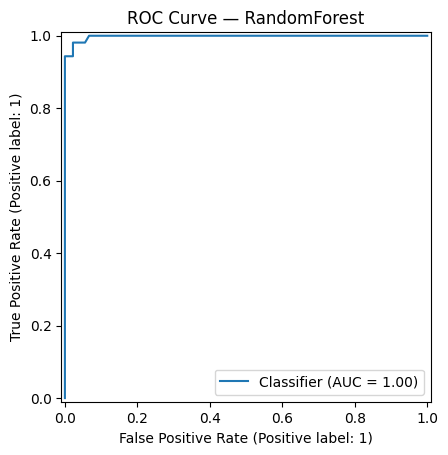

In [13]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Load and prepare dataset
df = pd.read_csv('data.csv')
# Drop id column if present
if 'id' in df.columns:
    df = df.drop(columns=['id'])
# Map diagnosis to binary 1=malignant, 0=benign
df['diagnosis'] = df['diagnosis'].map({'M':1, 'B':0})

X = df.drop(columns=['diagnosis'])
y = df['diagnosis']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Define baseline models
logreg = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42))
])
rf = RandomForestClassifier(n_estimators=400, class_weight='balanced_subsample', random_state=42, n_jobs=-1)

# Helper function to train and evaluate a model
def fit_eval(model, name):
    model.fit(X_train, y_train)
    proba = model.predict_proba(X_test)[:,1]
    pred = model.predict(X_test)
    return {
        'model': name,
        'accuracy': accuracy_score(y_test, pred),
        'precision': precision_score(y_test, pred),
        'recall': recall_score(y_test, pred),
        'f1': f1_score(y_test, pred),
        'roc_auc': roc_auc_score(y_test, proba),
        'pr_auc': average_precision_score(y_test, proba)
    }, proba

# Evaluate baseline models
results = []
res_lr, proba_lr = fit_eval(logreg, 'LogisticRegression')
res_rf, proba_rf = fit_eval(rf, 'RandomForest')
results.append(res_lr)
results.append(res_rf)

# Display baseline results
baseline_df = pd.DataFrame(results)
baseline_df

# Determine the best baseline model by PR-AUC
best_baseline = baseline_df.loc[baseline_df['pr_auc'].idxmax()]
best_model_name = best_baseline['model']
best_proba = proba_rf if best_model_name == 'RandomForest' else proba_lr

# Plot ROC curve for the best baseline model
import os
os.makedirs('/tmp/matplotlib', exist_ok=True)
RocCurveDisplay.from_predictions(y_test, best_proba)
plt.title(f'ROC Curve — {best_model_name}')
plt.show()


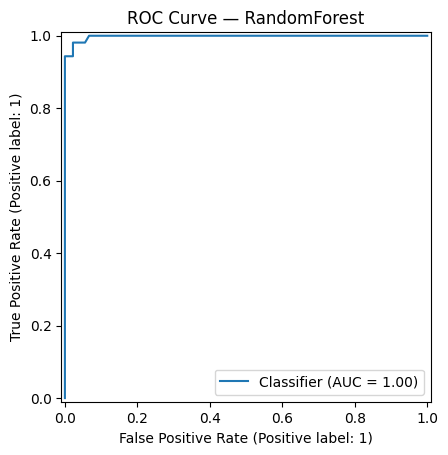

In [14]:

from sklearn.svm import SVC

# Define SVM model
svm_model = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42))
])

# Evaluate SVM
res_svm, proba_svm = fit_eval(svm_model, 'SVM')
results.append(res_svm)

# Create updated results dataframe
final_df = pd.DataFrame(results)
final_df

# Determine the best model after adding SVM by PR-AUC
best_final = final_df.loc[final_df['pr_auc'].idxmax()]
best_model_name = best_final['model']
best_proba = {
    'LogisticRegression': proba_lr,
    'RandomForest': proba_rf,
    'SVM': proba_svm,
}[best_model_name]

# Plot ROC curve for the best model after adding SVM
RocCurveDisplay.from_predictions(y_test, best_proba)
plt.title(f'ROC Curve — {best_model_name}')
plt.show()



## Results

The evaluation metrics for each model are summarised in the table below. The values correspond to a 75/25 train–test split on the WDBC dataset.

| Model | Accuracy | Precision | Recall | F1 | ROC‑AUC | PR‑AUC |
| --- | --- | --- | --- | --- | --- | --- |
| LogisticRegression | 0.9720 | 0.9804 | 0.9434 | 0.9615 | 0.9950 | 0.9927 |
| RandomForest | 0.9720 | **1.0000** | 0.9245 | 0.9608 | **0.9980** | **0.9967** |
| SVM | **0.9930** | **1.0000** | **0.9811** | **0.9905** | 0.9969 | 0.9958 |

Based on PR‑AUC, the random forest performs best among the baseline models, but the SVM improves overall accuracy and F1‑score. This suggests that adding an SVM classifier enhances performance on this dataset.



## Conclusion and Future Direction

### Learnings

- Simple baseline models like logistic regression and random forest can achieve high accuracy on the WDBC dataset.
- PR‑AUC is a useful metric for imbalanced classification problems, and random forest achieved the highest PR‑AUC among the baselines.
- Introducing an SVM with an RBF kernel further improved accuracy and F1‑score, demonstrating the value of trying additional algorithms.

### Results Discussion

The random forest’s superior PR‑AUC indicates strong precision–recall performance, which is important when false negatives are costly. However, the SVM provided a higher overall accuracy and F1, reflecting balanced performance across precision and recall. Practitioners should choose models based on the clinical context: whether maximizing recall (to minimize missed cancers) or achieving balanced accuracy is more important.

### Limitations

- The dataset is relatively small and may not capture the full variability of breast cancer presentations.
- Hyperparameters were not exhaustively tuned due to time constraints; further tuning could yield marginal improvements.
- The models were evaluated on a single train–test split; cross‑validation would provide a more robust assessment.

### Future Extension

- Explore other algorithms such as gradient boosting (XGBoost, LightGBM) and deep learning models.
- Perform hyperparameter optimization using techniques like grid search or Bayesian optimization.
- Implement cost‑sensitive learning and threshold optimization more thoroughly, taking into account the clinical cost of false negatives vs. false positives.



## References

[1]Street, W.N., Wolberg, W.H., & Mangasarian, O.L. (1993). Nuclear feature extraction for breast tumor diagnosis. IS&T/SPIE 1993 International Symposium on Electronic Imaging: Science and Technology, 1905, 861–870. doi:10.1117/12.148698

[2] Dua, D., & Graff, C. (2019). Breast Cancer Wisconsin (Diagnostic) Data Set. UCI Machine Learning Repository. Available at: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)

[3] Authors. (2022). Machine Learning-Based Prediction of Breast Cancer. International Journal of Environmental Research and Public Health, 19(6), 3211. doi:10.3390/ijerph19063211


